# LSTM을 이용한 텍스트 생성
* 데이터 다운로드: 캐글 New York Times Comments
* ArticlesApril2018.csv

In [1]:
from google.colab import files
up = files.upload()

Saving ArticlesApril2018.csv to ArticlesApril2018.csv


In [2]:
import pandas as pd

df = pd.read_csv('ArticlesApril2018.csv', encoding='latin1')
df.head(3)

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleadersâ Settlement Offer...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"âI understand that they could meet with us, ...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,Whatâs it like to eat at the second incarnat...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...


In [3]:
df.columns

Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')

## 데이터 전처리
* headline 컬럼만 사용

In [4]:
# Null이 있는 지 확인
df.headline.isnull().sum()

0

In [5]:
# headline 컬럼: 시리즈 타입 --> 리스트
headlines = df.headline.values.tolist()

In [6]:
headlines[:5]

['Former N.F.L. Cheerleadersâ\x80\x99 Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [7]:
len(headlines)

1324

In [8]:
# 노이즈 데이터('Unknown') 제거
headlines = [line for line in df.headline.values if line != 'Unknown']
len(headlines)

1214

In [9]:
headlines[:5]

['Former N.F.L. Cheerleadersâ\x80\x99 Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

In [10]:
# encoding, 구둣점 제거, 소문자로 변환
import re
def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^A-Za-z0-9 ]', '', s)
    return s.lower()

In [11]:
headlines = [preprocessing(line) for line in headlines]
headlines[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

## Keras 텍스트 전처리

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [13]:
# 단어 집합 생성
t = Tokenizer()
t.fit_on_texts(headlines)

In [14]:
# 단어 집합 크기 - Keras Tokenizer의 시작 인덱스가 1이기 때문
vocab_size = len(t.word_index) + 1
vocab_size

3494

In [15]:
sequences = []
for line in headlines:
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)
        
sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

In [16]:
max_len = max(len(seq) for seq in sequences)
max_len

24

In [17]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
sequences[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          99,  269],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   99,
         269,  371],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   99,  269,
         371, 1115]], dtype=int32)

In [18]:
X = sequences[:,:-1]
y = sequences[:,-1]
Y = to_categorical(y)
X.shape, Y.shape

((7803, 23), (7803, 3494))

## 모델 정의/설정/학습
* Embedding: 5 차원
* LSTM: 64 units

In [19]:
import numpy as np 
import tensorflow as tf
seed=2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [21]:
# 임베딩 벡터 5차원, LSTM 노드 크기 64
model = Sequential([ 
    Embedding(vocab_size, 5, input_length=max_len-1),
    LSTM(64),
    Dense(vocab_size, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 5)             17470     
                                                                 
 lstm (LSTM)                 (None, 64)                17920     
                                                                 
 dense (Dense)               (None, 3494)              227110    
                                                                 
Total params: 262,500
Trainable params: 262,500
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

In [23]:
# Colab, GPU 환경
%time hist = model.fit(X, Y, epochs=200, verbose=0)

CPU times: user 4min 38s, sys: 31.6 s, total: 5min 9s
Wall time: 3min 54s


In [24]:
hist.history['accuracy'][-1]

0.7848263382911682

## 모델 검증

In [25]:
up = files.upload()

Saving my_util.py to my_util.py


In [26]:
from my_util import sentence_generation

In [27]:
print(sentence_generation(model, t, max_len, 'former', 10))
print(sentence_generation(model, t, max_len, 'epa', 10))
print(sentence_generation(model, t, max_len, 'how', 10))

former plan for nuts 5 raising prospect of missile strike as
epa and honor out sick the lone bellow just a cathedral
how the best time in human history to be alive say


## 훈련과정 시각화

In [30]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
xs = np.arange(1, len(y_acc)+1)

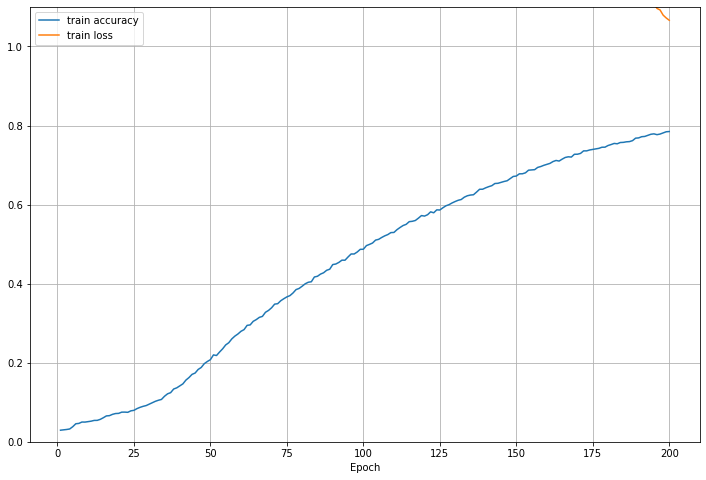

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_loss, label='train loss')
plt.legend(), plt.grid(), plt.ylim(0, 1.1)
plt.xlabel('Epoch')
plt.show()